# 01 - Tax Burden by State

Calculate the total effective tax burden on individuals per state, including both state and federal payroll taxes.

**Taxes included:**
- State income tax
- Property tax
- Sales tax
- State fees
- Social Security (FICA) — 6.2% employee share
- Medicare — 1.45% employee share
- FMLA / State Paid Family & Medical Leave (varies by state)

**Data sources:**
- Census Bureau State Tax Collections
- Bureau of Economic Analysis (personal income by state)
- SSA (Social Security rates)
- DOL / state agencies (PFML programs)

**Output:** `tax_burden.csv`, `tax_burden.json`

In [1]:
import sys, os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

# allow imports from src/
sys.path.insert(0, str(Path("..").resolve()))
from src.data_utils import download_file, load_census_stc, fetch_bea_personal_income, fetch_state_population

load_dotenv(Path("../.env"))

RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

# Load state population data for per-capita calculations
population = fetch_state_population()
print(f"{len(population)} states with population data")

Using embedded Census 2023 population data
51 states with population data


In [2]:
# Federal payroll tax rates (2024, flat across all states)
SOCIAL_SECURITY_RATE = 0.062  # employee share, up to wage base
MEDICARE_RATE = 0.0145        # employee share, no cap

# States with Paid Family & Medical Leave programs and their employee contribution rates
# Source: individual state PFML program documentation
STATE_PFML_RATES = {
    "CA": 0.009,   # SDI + PFL
    "CO": 0.0045,  # FAMLI
    "CT": 0.005,   # CT Paid Leave
    "DE": 0.005,   # Healthy Delaware Families Act (2026)
    "MA": 0.00318, # PFML
    "MD": 0.0025,  # FAMLI (2026)
    "MN": 0.005,   # PFML (2026)
    "NJ": 0.006,   # TDI + FLI
    "NY": 0.00455, # PFL + DBL
    "OR": 0.006,   # PFMLI
    "RI": 0.011,   # TCI
    "WA": 0.0058,  # PFML
}

In [3]:
# Download Census State Tax Collections (FY2024, transposed Excel)
STC_URL = "https://www2.census.gov/programs-surveys/stc/tables/2024/FY2024-STC-Category-Table-Transposed.xlsx"
stc_path = download_file(STC_URL, RAW_DIR / "stc_2024.xlsx")

Already downloaded: ../data/raw/stc_2024.xlsx


In [4]:
# Parse & clean the STC data
stc = load_census_stc(stc_path)
print(f"{len(stc)} rows, {stc['state'].nunique()} states")

# Add human-readable amount column (amounts are in thousands of $)
stc["amount_display"] = stc["amount"].apply(
    lambda x: f"${x/1e6:,.1f}B" if pd.notna(x) and abs(x) >= 1e6
    else (f"${x/1e3:,.1f}M" if pd.notna(x) and abs(x) >= 1e3
    else (f"${x:,.0f}K" if pd.notna(x) else "N/A"))
)
stc[["state", "state_name", "category", "amount_display"]].head(10)

400 rows, 50 states


,state,state_name,category,amount_display
0,AL,Alabama,Total Taxes,$16.9B
1,AL,Alabama,Property Taxes,$620.7M
2,AL,Alabama,Sales and Gross Receipts Taxes,$8.1B
3,AL,Alabama,License Taxes,$612.5M
4,AL,Alabama,Income Taxes,$7.5B
5,AL,Alabama,Other Taxes,$93.0M
6,AL,Alabama,Footnotes,N/A
7,AL,Alabama,X - Not available.,N/A
8,AK,Alaska,Total Taxes,$2.0B
9,AK,Alaska,Property Taxes,$130.9M


In [5]:
# Extract total state tax collections per state
total_label = stc[stc["category"].str.contains("Total", case=False, na=False)]["category"].unique()
print("Categories containing 'Total':", total_label)

total_cat = [c for c in total_label if "total tax" in c.lower() or c.strip().lower() == "total"]
if total_cat:
    total_cat = total_cat[0]
else:
    total_cat = total_label[0]
print(f"Using category: '{total_cat}'")

state_taxes = (
    stc[stc["category"] == total_cat][["state", "state_name", "amount"]]
    .rename(columns={"amount": "total_state_taxes"})
    .reset_index(drop=True)
)

# Display with readable units (values are in thousands of $)
display_df = state_taxes.copy()
display_df["total_state_taxes_display"] = display_df["total_state_taxes"].apply(
    lambda x: f"${x/1e6:,.1f}B" if x >= 1e6 else f"${x/1e3:,.1f}M"
)
display_df[["state", "state_name", "total_state_taxes_display"]].head()

Categories containing 'Total': ['Total Taxes']
Using category: 'Total Taxes'


,state,state_name,total_state_taxes_display
0,AL,Alabama,$16.9B
1,AK,Alaska,$2.0B
2,AZ,Arizona,$23.6B
3,AR,Arkansas,$12.7B
4,CA,California,$265.6B


In [6]:
# Fetch personal income by state from BEA API
BEA_API_KEY = os.environ.get("BEA_API_KEY", "")
if not BEA_API_KEY:
    raise EnvironmentError(
        "BEA_API_KEY not found. Create a .env file in the project root with:\n"
        "  BEA_API_KEY=your-key-here\n"
        "Register at https://apps.bea.gov/api/signup/"
    )

income = fetch_bea_personal_income(BEA_API_KEY, year="2023")
print(f"{len(income)} states with personal income data")

# Display with readable units (values are in millions of $)
display_df = income.copy()
display_df["personal_income_display"] = display_df["personal_income"].apply(
    lambda x: f"${x/1e6:,.1f}T" if x >= 1e6 else f"${x/1e3:,.1f}B"
)
display_df[["state", "state_name", "personal_income_display"]].head()

49 states with personal income data


,state,state_name,personal_income_display
0,AL,Alabama,$279.5B
1,AZ,Arizona,$471.0B
2,AR,Arkansas,$173.6B
3,CA,California,$3.2T
4,CO,Colorado,$473.1B


In [7]:
# Calculate tax burden per state
burden = state_taxes.merge(income[["state", "personal_income"]], on="state", how="inner")

# State tax burden as a fraction of personal income
# Census STC amounts are in thousands of dollars
# BEA SAINC1 Line 1 is in millions of dollars — multiply by 1000 to align units
burden["state_tax_rate"] = burden["total_state_taxes"] / (burden["personal_income"] * 1000)

# Federal payroll taxes (same for every state)
burden["ss_rate"] = SOCIAL_SECURITY_RATE
burden["medicare_rate"] = MEDICARE_RATE

# State PFML (0 for states without a program)
burden["pfml_rate"] = burden["state"].map(STATE_PFML_RATES).fillna(0.0)

# Total effective burden
burden["federal_payroll_rate"] = burden["ss_rate"] + burden["medicare_rate"]
burden["total_burden"] = (
    burden["state_tax_rate"]
    + burden["federal_payroll_rate"]
    + burden["pfml_rate"]
)

def fmt_millions(x):
    """Format value in millions of $ to human-readable."""
    if x >= 1e6:
        return f"${x/1e6:,.1f}T"
    if x >= 1e3:
        return f"${x/1e3:,.1f}B"
    return f"${x:,.0f}M"

def fmt_thousands(x):
    """Format value in thousands of $ to human-readable."""
    if x >= 1e6:
        return f"${x/1e6:,.1f}B"
    if x >= 1e3:
        return f"${x/1e3:,.1f}M"
    return f"${x:,.0f}K"

print(f"States: {len(burden)}")
print(f"State tax rate range: {burden['state_tax_rate'].min():.2%} – {burden['state_tax_rate'].max():.2%}")
print(f"Total burden range:   {burden['total_burden'].min():.2%} – {burden['total_burden'].max():.2%}")

display_df = burden[["state", "state_name", "total_state_taxes", "personal_income",
                      "state_tax_rate", "total_burden"]].copy()
display_df["total_state_taxes"] = display_df["total_state_taxes"].apply(fmt_thousands)
display_df["personal_income"] = display_df["personal_income"].apply(fmt_millions)
display_df["state_tax_rate"] = display_df["state_tax_rate"].apply(lambda x: f"{x:.2%}")
display_df["total_burden"] = display_df["total_burden"].apply(lambda x: f"{x:.2%}")
display_df.sort_values("state_name").head(10)

States: 48
State tax rate range: 3.23% – 11.64%
Total burden range:   10.88% – 19.29%


,state,state_name,total_state_taxes,personal_income,state_tax_rate,total_burden
0,AL,Alabama,$16.9B,$279.5B,6.05%,13.70%
1,AZ,Arizona,$23.6B,$471.0B,5.01%,12.66%
2,AR,Arkansas,$12.7B,$173.6B,7.30%,14.95%
3,CA,California,$265.6B,$3.2T,8.34%,16.89%
4,CO,Colorado,$18.5B,$473.1B,3.90%,12.00%
5,CT,Connecticut,$23.2B,$328.7B,7.06%,15.21%
6,DE,Delaware,$6.5B,$66.9B,9.76%,17.91%
7,FL,Florida,$63.1B,$1.6T,3.93%,11.58%
8,GA,Georgia,$33.6B,$663.9B,5.07%,12.72%
9,ID,Idaho,$8.3B,$116.7B,7.14%,14.79%


In [8]:
# Add per-capita tax amounts
burden = burden.merge(population[["state", "population"]], on="state", how="left")

# total_state_taxes is in thousands of $ → convert to actual $ for per-capita
burden["taxes_per_capita"] = (burden["total_state_taxes"] * 1000) / burden["population"]

print(f"Per-capita state tax range: ${burden['taxes_per_capita'].min():,.0f} – ${burden['taxes_per_capita'].max():,.0f}")

# Export to CSV and JSON
export_cols = [
    "state", "state_name", "total_state_taxes", "personal_income", "population",
    "state_tax_rate", "ss_rate", "medicare_rate", "pfml_rate",
    "federal_payroll_rate", "total_burden", "taxes_per_capita",
]
out = burden[export_cols].sort_values("state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "tax_burden.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "tax_burden.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

Per-capita state tax range: $2,558 – $7,460
Wrote ../data/processed/tax_burden.csv
Wrote ../docs/charts/data/tax_burden.json


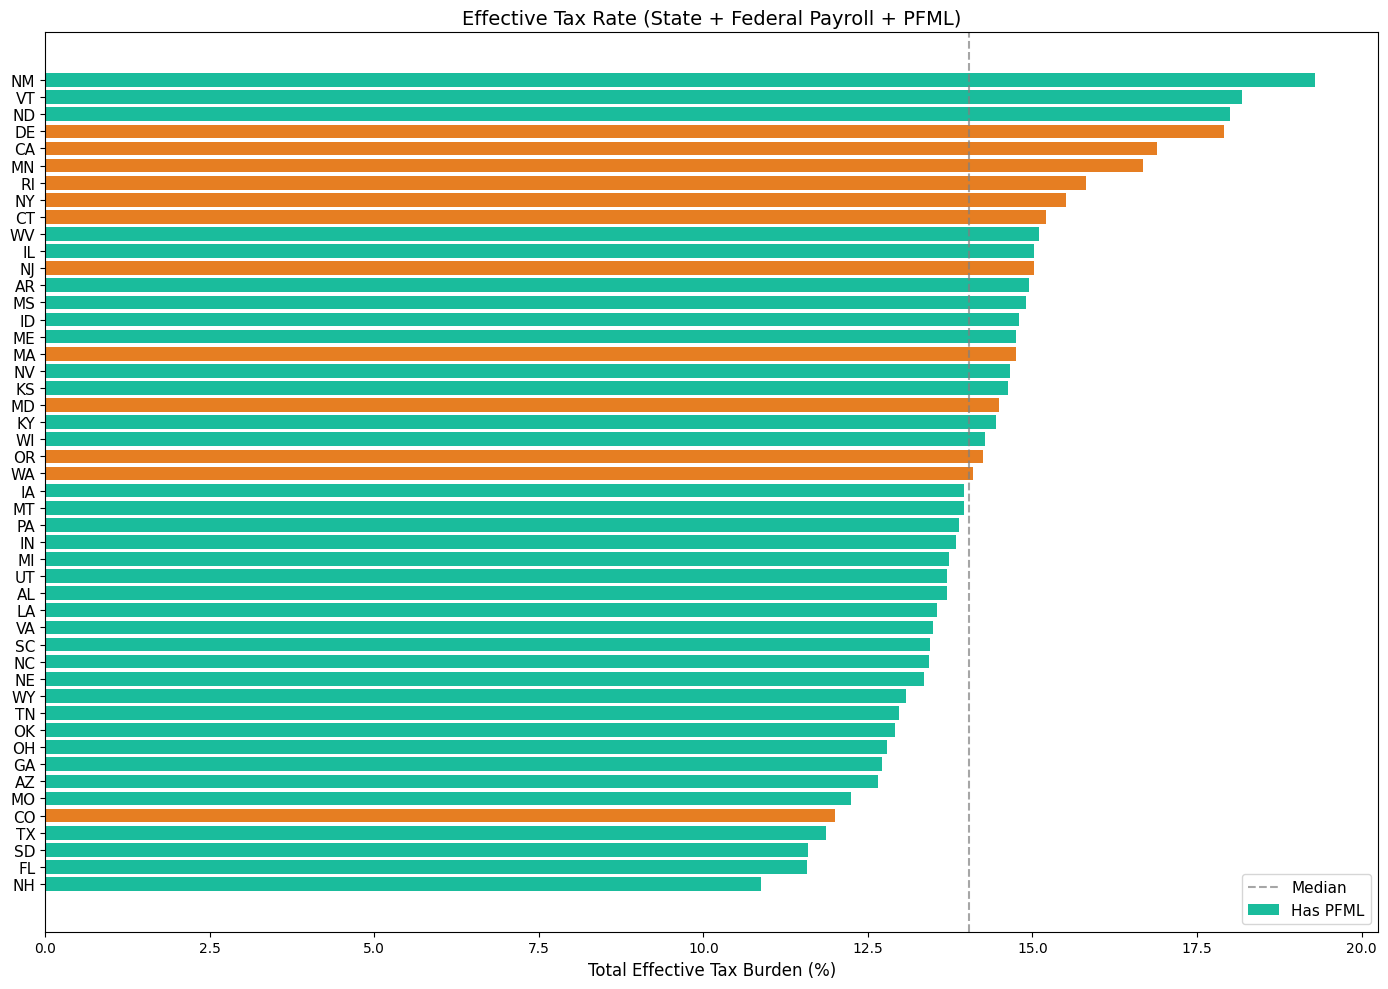

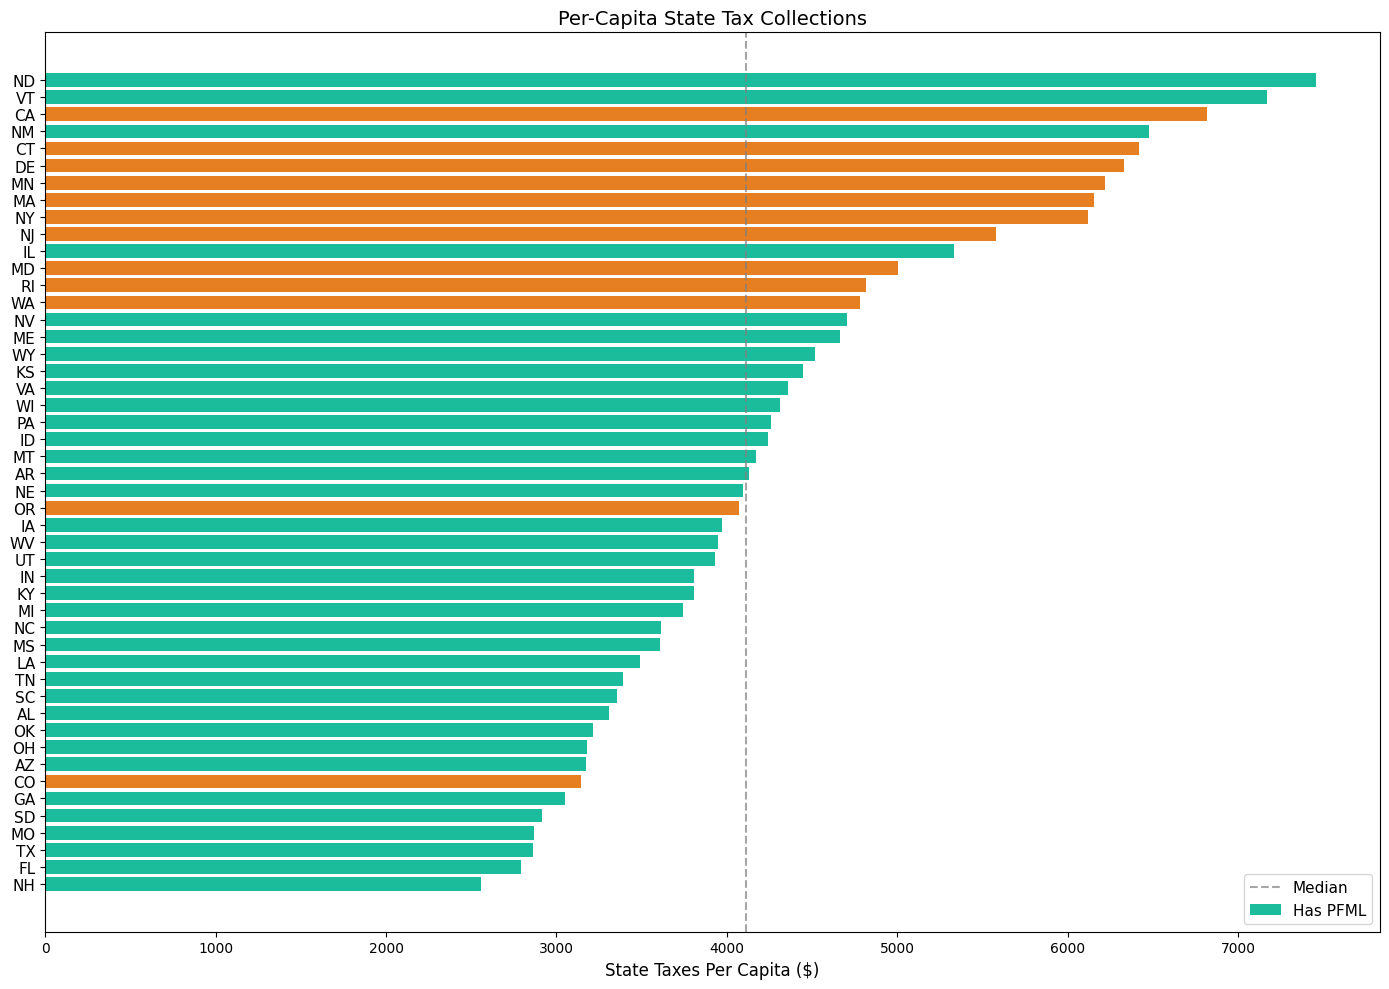

In [9]:
# Visualization — tax burden by state

# 1. Total effective tax rate
fig, ax = plt.subplots(figsize=(14, 10))
plot_data = out.sort_values("total_burden", ascending=True)
colors = ["#e67e22" if s in STATE_PFML_RATES else "#1abc9c" for s in plot_data["state"]]
ax.barh(plot_data["state"], plot_data["total_burden"] * 100, color=colors)
ax.set_xlabel("Total Effective Tax Burden (%)", fontsize=12)
ax.set_title("Effective Tax Rate (State + Federal Payroll + PFML)", fontsize=14)
ax.axvline(x=plot_data["total_burden"].median() * 100, color="gray", linestyle="--", alpha=0.7, label="Median")
ax.tick_params(axis="y", labelsize=11)
ax.legend(["Median", "Has PFML", "No PFML"], fontsize=11)
plt.tight_layout()
plt.show()

# 2. Per-capita state taxes
fig, ax = plt.subplots(figsize=(14, 10))
plot_data2 = out.sort_values("taxes_per_capita", ascending=True)
colors2 = ["#e67e22" if s in STATE_PFML_RATES else "#1abc9c" for s in plot_data2["state"]]
ax.barh(plot_data2["state"], plot_data2["taxes_per_capita"], color=colors2)
ax.set_xlabel("State Taxes Per Capita ($)", fontsize=12)
ax.set_title("Per-Capita State Tax Collections", fontsize=14)
ax.axvline(x=plot_data2["taxes_per_capita"].median(), color="gray", linestyle="--", alpha=0.7, label="Median")
ax.tick_params(axis="y", labelsize=11)
ax.legend(["Median", "Has PFML", "No PFML"], fontsize=11)
plt.tight_layout()
plt.show()